In [1]:
import random as random
import time as time
import heapq as heapq
import matplotlib.pyplot as plt # 画曲线图
import numpy as np #拟合直线
from src.Data import HyperNode,HyperEdge,Heap,load_data,recoder

# return: part_node,part_edge
def solve(p,mp_node,mp_edge,prop = 1.0,k=1,shield_heavy_edge = 1e9 ,buffer_fac = 5,debug = False):
    # input : 
    # p: partition number 
    # mp_node: dict of partition nodes  
    # mp_edge: dict of partition edges
    # prob: accelerate factory to add node
    # k: select topk node at once
    # shield_heavy_node: filter huge edge 
    # debug: print debug infomation
    
    # return :
    # part_node: list of partition node set 
    # part_edge: list of partition edge set
    
    random.seed(19990320)
    node_number = len(mp_node)
    cur_p = 0
    maxi_cap = node_number/p + 1
    part_node = [set() for i in range(p)]
    part_edge = [set() for i in range(p)]
    mp_eval = {i:0 for i in mp_node.keys()}
    
    ave_hyperedge_degree = 0
    edge_degree_list = set()
    for edge in mp_edge.values():   
        ave_hyperedge_degree += edge.degree/len(mp_edge)
        edge_degree_list.add(edge.degree)
#     print(edge_degree_list)
    edge_degree_list = list(edge_degree_list)
    edge_degree_list.sort()
#     print(edge_degree_list)
#     print(len(mp_edge)/2)
#     print("2*ave:",ave_hyperedge_degree," mid:",edge_degree_list[int(len(edge_degree_list)/2)])
    ave_hyperedge_degree = edge_degree_list[int(len(edge_degree_list)/2)]

    cnt = 0
    select_node = Heap()
    heap_size = buffer_fac*k*2
    while len(mp_node)!=0:
        cnt += 1
        if cnt % 100 == 0 and debug : print (cnt)
            
        add_node = []
        
        if select_node.size() <= heap_size/2:
            select_node.clear()
            for node in mp_node.values():   
                if  select_node.size() < heap_size:
                    select_node.add(mp_eval[node.id],node)
                else :
                    if mp_eval[node.id] > select_node.top()[0] :
                        rank,remove_node = select_node.pop()
                        select_node.add(mp_eval[node.id],node)
        
        for i in range(min(k,select_node.size())):
            rank,node = select_node.pop()
            add_node.append(node)

        for par_node in add_node:
            if len(part_node[cur_p]) >= maxi_cap :
                break
            part_node[cur_p].add(par_node)
            for edge in par_node.edges:
                if edge not in part_edge[cur_p]:
                    part_edge[cur_p].add(edge)
                    if mp_edge[edge].degree > shield_heavy_edge: continue
                    for node in mp_edge[edge].nodes:
                        if mp_node.get(node) == None : continue
                        mp_eval[node] += 1
#                         print(len(select_node))
            del mp_node[par_node.id] 
        remake_ls = [(mp_eval[node.id],node) for rank,node in select_node.heap]
#         print(remake_ls)
        select_node.remake(remake_ls)

        if len(part_node[cur_p]) >= maxi_cap : # next partition pre-process
            for key in mp_eval.keys():
                mp_eval[key] = 0
            cur_p += 1   
            
    return part_node,part_edge
        
        
def solve2(p,mp_node,mp_edge,prop = 1.0,k=1,shield_heavy_edge = 1e9 ,buffer_fac = 5,debug = False):
    # input : 
    # p: partition number 
    # mp_node: dict of partition nodes  
    # mp_edge: dict of partition edges
    # prob: accelerate factory to add node
    # k: select topk node at once
    # shield_heavy_node: filter huge edge 
    # debug: print debug infomation
    
    # return :
    # part_node: list of partition node set 
    # part_edge: list of partition edge set
    
    random.seed(19990320)
    node_number = len(mp_node)
    cur_p = 0
    maxi_cap = node_number/p + 1
    part_node = [set() for i in range(p)]
    part_edge = [set() for i in range(p)]
    mp_eval = {i:0 for i in mp_node.keys()}

    cnt = 0
    select_node = Heap()
    heap_size = buffer_fac*k
    
    while len(mp_node)!=0:
        cnt += 1
        if cnt % 100 == 0 and debug : print (cnt)
            
        add_node = []
        
        if select_node.size() <= heap_size/2:
            select_node.clear()
            for node in mp_node.values(): 
#                 if mp_eval[node.id] == 0 : 
#                     if select_node.size() < heap_size : 
#                         select_node.add(-1e9,node)
#                     continue
                if  select_node.size() < heap_size:
                    select_node.add(mp_eval[node.id] - node.degree,node)
                else :
                    if mp_eval[node.id] - node.degree > select_node.top()[0] :
                        rank,remove_node = select_node.pop()
                        select_node.add(mp_eval[node.id] - node.degree,node)
        
        for i in range(min(k,select_node.size())):
            rank,node = select_node.pop()
            add_node.append(node)

        for par_node in add_node:
            if len(part_node[cur_p]) >= maxi_cap :
                break
            part_node[cur_p].add(par_node)
            for edge in par_node.edges:
                if edge not in part_edge[cur_p]:
                    part_edge[cur_p].add(edge)
                    if mp_edge[edge].degree > shield_heavy_edge: continue
                    for node in mp_edge[edge].nodes:
                        if mp_node.get(node) == None : continue
                        mp_eval[node] += 1
#                         print(len(select_node))
            del mp_node[par_node.id] 
        remake_ls = [(mp_eval[node.id]-node.degree,node)for rank,node in select_node.heap]
        select_node.remake(remake_ls)

        if len(part_node[cur_p]) >= maxi_cap : # next partition pre-process
            for key in mp_eval.keys():
                mp_eval[key] = 0
            cur_p += 1   
            
    return part_node,part_edge



def degree_distribute(mp_node,show = True,logx=True,logy=True,coeff = True,cumulation = True): # draw degree distribute graph 
    degree = mp_node
    dic = {j.degree:0 for i,j in degree.items()}
    
    for i,j in degree.items(): dic[j.degree] += 1
    
    ls = sorted(dic.items(), key = lambda x:(x[0],x[1]))
        
    x = [i[0] for i in ls]
    y = [i[1] for i in ls]

    if x[0] == 0:
        x = x[1:-1]
        y = y[1:-1]
    
    if cumulation == True : 
        cnt = sum(y)
        for i in range(len(x)):
            cnt -= y[i]
            y[i] += cnt

    if show == True :
        plt.plot(x,y, 'o',color='b')
        if logy : plt.yscale('log')
        if logx : plt.xscale('log')
        

    if coeff == True : 

        xx = [np.log2(i) for i in x]
        yy = [np.log2(i) for i in y]
        
        k,b = np.polyfit(xx, yy, 1)
#         lg = yy[0]/xx[-1]
#         lg = 1/lg
        print("alpha: "+str(k))
        
        xx = x
        yy = [(i**k)*(2**b) for i in xx]
        plt.plot(xx,yy,color='r')
    plt.show()

    return [(x[i],y[i]) for i in range(len(x))]


data set: ./data/wiki/wiki.txt
alpha: -1.733355505918805


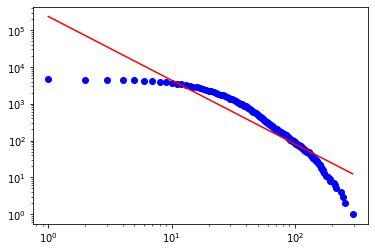

parameter:
 p: 2  prop: 1.10  k: 1  buffer_fac: 1  sheld_size: 1000000000.0
result1:
 runtime: 4613 ms k-1: 3099
2   3884
2   3348
result2:
 runtime: 6284 ms k-1: 2447
2   2601
2   3979
---------------------------------------
parameter:
 p: 4  prop: 1.10  k: 1  buffer_fac: 1  sheld_size: 1000000000.0


KeyboardInterrupt: 

In [2]:
# path = "./data/github/github.txt"
path = "./data/wiki/wiki.txt"

print("data set:",path)
p = 1
mp_node,mp_edge = load_data(path)
ls = degree_distribute(mp_node)
for turn in range(8):
    p*=2
    prop = 1.1
    k = 1
    buffer_fac = 1
    shield_heavy_edge = 1e9
    print("parameter:\n","p:",p," prop:","%.2f"%prop," k:",k," buffer_fac:",buffer_fac,
      " sheld_size:",shield_heavy_edge)
        
    mp_node,mp_edge = load_data(path)
#     degree_distribute(mp_node)
    time_beg = time.time()
    part_node,part_edge = solve(p,mp_node,mp_edge,prop,k,buffer_fac = buffer_fac,shield_heavy_edge = shield_heavy_edge)  
    time_end = time.time()
    mp_node,mp_edge = load_data(path)
    # recoder(part_node,mp_node,mp_edge,"./data/wiki")
    k_1 = sum([len(i) for i in part_edge]) - len(mp_edge)
#     print(turn," ",k_1)
    print("result1:\n","runtime:",int((time_end-time_beg)*1000),"ms k-1:",k_1)
    for par in range(p):
        print(p," ",len(part_edge[par]))
    
    mp_node,mp_edge = load_data(path)
#     degree_distribute(mp_node)
    time_beg = time.time()
    part_node,part_edge = solve2(p,mp_node,mp_edge,prop,k,buffer_fac = buffer_fac,shield_heavy_edge = shield_heavy_edge)  
    time_end = time.time()
    mp_node,mp_edge = load_data(path)
    # recoder(part_node,mp_node,mp_edge,"./data/wiki")
    k_1 = sum([len(i) for i in part_edge]) - len(mp_edge)
    print("result2:\n","runtime:",int((time_end-time_beg)*1000),"ms k-1:",k_1)
    for par in range(p):
        print(p," ",len(part_edge[par]))
    print("---------------------------------------")
#  runtime: 11999 ms k-1: 27102
    

In [ ]:
def test_shield():
    x = []
    y = []
#     path = "./data/wiki/wiki.txt"
    path = "./data/github/github.txt"
    p = 16
    mp_node,mp_edge = load_data(path)
    ls = degree_distribute(mp_node)
    for turn in range(61,81):
    #     p*=2
        mp_node,mp_edge = load_data(path)
    #     degree_distribute(mp_node)
        time_beg = time.time()
        prop = 1.1
        k = 10
        buffer_fac = 1
        shield_heavy_edge = turn
        part_node,part_edge = solve(p,mp_node,mp_edge,prop,k,buffer_fac = buffer_fac,shield_heavy_edge = shield_heavy_edge)  
        time_end = time.time()
        mp_node,mp_edge = load_data(path)
        # recoder(part_node,mp_node,mp_edge,"./data/wiki")
        k_1 = sum([len(i) for i in part_edge]) - len(mp_edge)
#         print(turn," ",k_1)
        x.append(turn)
        y.append(k_1)
    plt.plot(x,y,color='r')
    plt.show()
    return x,y
    
x,y = test_shield()

In [6]:
path = "./data/github/github.txt"
mp_node,mp_edge = load_data(path)
ls = degree_distribute(mp_node)
sum = 0
p60 = 0
p80 = 0
for i,j in ls:
    if i < 60 : p60 += j
    if i < 80 : p80 += j
    sum += j
print(p60/sum*100," ",p80/sum*100)

TypeError: 'int' object is not callable

In [5]:
for i in range(len(x)):
    print(x)

NameError: name 'x' is not defined

In [23]:
tmp_node = [set() for i in range(p)]

for par in range(len(part_edge)):
    for i in part_node[par]: tmp_node[par].add(i.id)
    cnt = 0
    print("edges:"+str(len(part_edge[par])))
    print("nodes:"+str(len(part_node[par])))
    for edge in part_edge[par]:
        for node in mp_edge[edge].nodes:
#             print(node)
#             print(mp_node[node])
            if node in tmp_node[par]:
                cnt += 1
    cur_p += 1
    print(cnt)
    

edges:56433
nodes:5653
277912
edges:25730
nodes:5653
59056
edges:15618
nodes:5653
28610
edges:7641
nodes:5653
14208
edges:7349
nodes:5653
12455
edges:7531
nodes:5653
11444
edges:7756
nodes:5653
10089
edges:8023
nodes:5653
9310
edges:7767
nodes:5653
8748
edges:7984
nodes:5642
8405


In [4]:
k_1 = sum([len(i) for i in part_edge]) - edge_number
print(k_1)

30965
